In [1]:
import pandas as pd
import pyam

<IPython.core.display.Javascript object>

In [2]:
df = pd.DataFrame([
    ['IMG', 'a_scen', 'World', 'Emissions|CO2', 'Mt CO2/yr', 4, 9.4],
    ['IMG', 'a_scen', 'World', 'Emissions|CO2|Cars', 'Mt CO2/yr', 1.6, 3.8],
    ['IMG', 'a_scen', 'World', 'Emissions|CO2|Tar', 'Mt CO2/yr', -2.4, -5.6],
    ['IMG', 'a_scen_2', 'World', 'Emissions|CO2', 'Mt CO2/yr', 4.8, 10.2],
    ['IMG', 'a_scen_2', 'World', 'Emissions|CO2|Cars', 'Mt CO2/yr', 2.0, 4.2],
    ['IMG', 'a_scen_2', 'World', 'Emissions|CO2|Tar', 'Mt CO2/yr', 2.8, 6.0],
    ['MSG-GLB', 'a_scen', 'World', 'Emissions|CO2', 'Mt CO2/yr', 3.6, 9.0],
    ['MSG-GLB', 'a_scen', 'World', 'Emissions|CO2|Cars', 'Mt CO2/yr', 1.4, 3.6],
    ['MSG-GLB', 'a_scen', 'World', 'Emissions|CO2|Tar', 'Mt CO2/yr', 2.2, 5.4],
    ['MSG-GLB', 'a_scen_2', 'World', 'Emissions|CO2', 'Mt CO2/yr', -5.0, -10.6],
    ['MSG-GLB', 'a_scen_2', 'World', 'Emissions|CO2|Cars', 'Mt CO2/yr', -2.0, -4.2],
    ['MSG-GLB', 'a_scen_2', 'World', 'Emissions|CO2|Tar', 'Mt CO2/yr', -2.8, -6.0],
    ['MSG-GLB', 'a_scen_2', 'World', 'Emissions|CO2|Agg Agg', 'Mt CO2/yr', -0.2, -0.4],
],
    columns=['model', 'scenario', 'region', 'variable', 'unit', 2005, 2010],
)

In [3]:
df.head()

,model,scenario,region,variable,unit,2005,2010
0,IMG,a_scen,World,Emissions|CO2,Mt CO2/yr,4.0,9.4
1,IMG,a_scen,World,Emissions|CO2|Cars,Mt CO2/yr,1.6,3.8
2,IMG,a_scen,World,Emissions|CO2|Tar,Mt CO2/yr,-2.4,-5.6
3,IMG,a_scen_2,World,Emissions|CO2,Mt CO2/yr,4.8,10.2
4,IMG,a_scen_2,World,Emissions|CO2|Cars,Mt CO2/yr,2.0,4.2


In [4]:
df = pyam.IamDataFrame(df)

Stack_plot function scripted below

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def stack_plot_emissions(pyam_df, list_of_variables):

    # Filter the dataframe based on function arguments.
    test = pyam_df.filter(variable=list_of_variables)


    # Interpolate and get the zeros of each variable.
    years = np.array(test['year'].drop_duplicates())
    lines_to_plot = {}
    for var in test.variables():
        lines_to_plot[var]=np.array(test[test['variable']==var]['value'])

    years_fine = np.linspace(years[0], years[-1], 5000)
    lines_to_plot_fine = {}
    for label, data in lines_to_plot.items():
        lines_to_plot_fine[label] = np.interp(years_fine, years, data)

    last_positive = {}
    for label, data in lines_to_plot_fine.items():        
        first_zero_point = np.argmax(data <= 0)
        
        if (first_zero_point == 0) and (data[0] >= 0):
            first_zero_point = len(data)
        
        last_positive[label] = first_zero_point - 1

    if not (4999 in last_positive.values()):
        last_positive['Last Value']=len(years_fine)-1


    # Get plot order based on increasing index when variables pass time-axis.
    plot_order = []
    for last_positive_point in sorted(list(last_positive.values())):
        for label, lpp in last_positive.items():
            if (lpp == last_positive_point) and (label not in plot_order):
                plot_order.append(label)
                break


    # Plot the stack plot based on plot order.
    colours = {}
    colour = ['green', 'blue', 'purple', 'turquoise', 'red', 'yellow', 'orange', 'aqua', 'brown', 'gold', 'fuchsia', 'indigo', 'lavender', 'violet']
    for i, var in enumerate(plot_order):
        colours[var]=colour[i]

    start = 0
    data_to_plot = lines_to_plot_fine
    fig, ax = plt.subplots(figsize=(16, 9))

    for i, end in enumerate(sorted(list(last_positive.values()))):
        plot_points = np.zeros(len(years_fine), dtype=bool)
        plot_points[start:end] = True
    
        section_data = {}
        section_negative_bottom = 0
    
        for label, data in lines_to_plot_fine.items():
            section_label_data = lines_to_plot_fine[label][plot_points]
            if (section_label_data < 0).any():
                section_negative_bottom += section_label_data
            
            section_data[label] = section_label_data
        
        bottom = 0
        for j, label in enumerate(plot_order):  # Excluded last element of plot_order to avoid KeyError.
            if label == 'Last Value':
                pass
            else:
                ts_data = section_data[label]
                is_negative = (ts_data < 0).any()

                if is_negative and (j == 0):
                    bottom = section_negative_bottom
                    top = bottom - ts_data
                elif is_negative:
                    top = bottom - ts_data
                else:
                    top = bottom + ts_data

                if isinstance(bottom, np.ndarray):
                    reset_bottom = not is_negative and (bottom < 0).any()
                else:
                    reset_bottom = not is_negative and (bottom < 0)

                if reset_bottom:
                    bottom = 0

                plt_args = {
                    "color": colours[label],
                    "alpha": 0.6,
                }
                if i == 0:
                    plt_args["label"] = label

                ax.fill_between(
                    years_fine[plot_points],
                    top,
                    bottom,
                    **plt_args
                )

                if is_negative:
                    bottom -= ts_data
                else:
                    bottom += ts_data       

        start = end
    
    total = 0
    for val in lines_to_plot_fine.values():
        total += val
    
    ax.plot(
        years_fine, 
        total, 
        label="Total", 
        color="black", 
        lw=4.0
    )
    ax.legend();


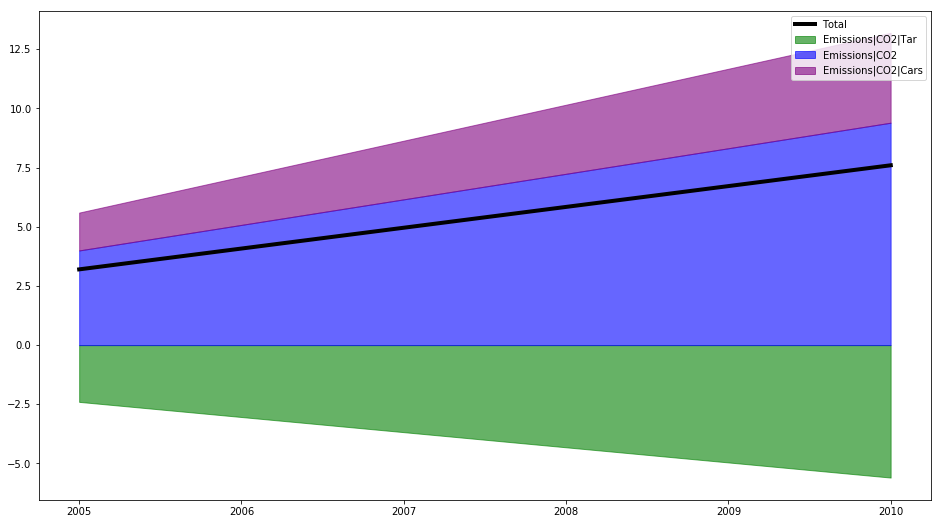

In [6]:
#df.filter(scenario='a_scen', model='IMG').stack_plot()
plot_df = df.filter(scenario='a_scen', model='IMG')
var = list(plot_df.variables())
stack_plot_emissions(plot_df, var)

In [7]:
df.filter(scenario='a_scen', model='IMG').data

,model,scenario,region,variable,unit,year,value
0,IMG,a_scen,World,Emissions|CO2,Mt CO2/yr,2005,4.0
13,IMG,a_scen,World,Emissions|CO2,Mt CO2/yr,2010,9.4
1,IMG,a_scen,World,Emissions|CO2|Cars,Mt CO2/yr,2005,1.6
14,IMG,a_scen,World,Emissions|CO2|Cars,Mt CO2/yr,2010,3.8
2,IMG,a_scen,World,Emissions|CO2|Tar,Mt CO2/yr,2005,-2.4
15,IMG,a_scen,World,Emissions|CO2|Tar,Mt CO2/yr,2010,-5.6


From here down we want to make the stack plot with the bars showing the negative emissions and total lines properly.

In [8]:
var = ['Emissions|CO2', 'Emissions|CO2|Cars']
df_plot = df.filter(scenario='a_scen', model='IMG', variable=var)

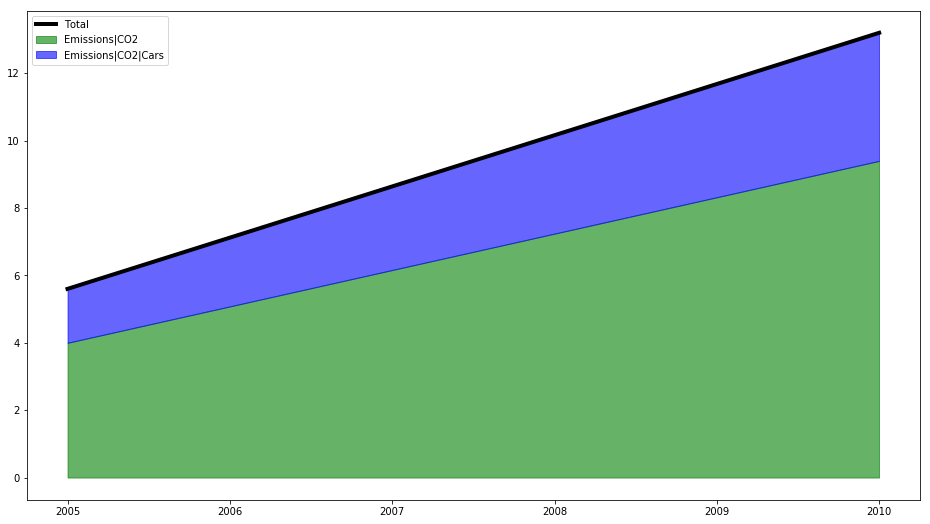

In [9]:
stack_plot_emissions(df_plot, var)

From here down we want to aggregate some data first, then make the stack plot

In [10]:
sdf = df.filter(model="MSG-GLB", scenario="a_scen_2")

In [14]:
sdf.head()
sdf.data
#.aggregate(variable='agg',append=True)

,model,scenario,region,variable,unit,year,value
9,MSG-GLB,a_scen_2,World,Emissions|CO2,Mt CO2/yr,2005,-5.0
22,MSG-GLB,a_scen_2,World,Emissions|CO2,Mt CO2/yr,2010,-10.6
12,MSG-GLB,a_scen_2,World,Emissions|CO2|Agg Agg,Mt CO2/yr,2005,-0.2
25,MSG-GLB,a_scen_2,World,Emissions|CO2|Agg Agg,Mt CO2/yr,2010,-0.4
10,MSG-GLB,a_scen_2,World,Emissions|CO2|Cars,Mt CO2/yr,2005,-2.0
23,MSG-GLB,a_scen_2,World,Emissions|CO2|Cars,Mt CO2/yr,2010,-4.2
11,MSG-GLB,a_scen_2,World,Emissions|CO2|Tar,Mt CO2/yr,2005,-2.8
24,MSG-GLB,a_scen_2,World,Emissions|CO2|Tar,Mt CO2/yr,2010,-6.0


In [26]:
sdf.head()

,model,scenario,region,variable,unit,year,value
9,MSG-GLB,a_scen_2,World,Emissions|CO2,Mt CO2/yr,2005,-5.0
22,MSG-GLB,a_scen_2,World,Emissions|CO2,Mt CO2/yr,2010,-10.6
12,MSG-GLB,a_scen_2,World,Emissions|CO2|Agg Agg,Mt CO2/yr,2005,-0.2
25,MSG-GLB,a_scen_2,World,Emissions|CO2|Agg Agg,Mt CO2/yr,2010,-0.4
10,MSG-GLB,a_scen_2,World,Emissions|CO2|Cars,Mt CO2/yr,2005,-2.0


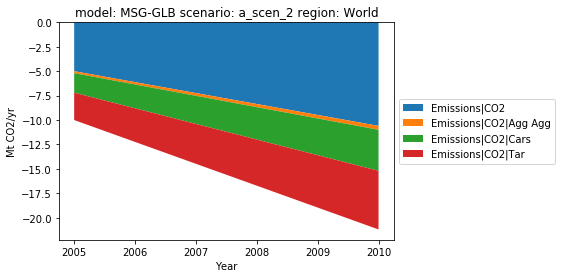

In [28]:
sdf.stack_plot()

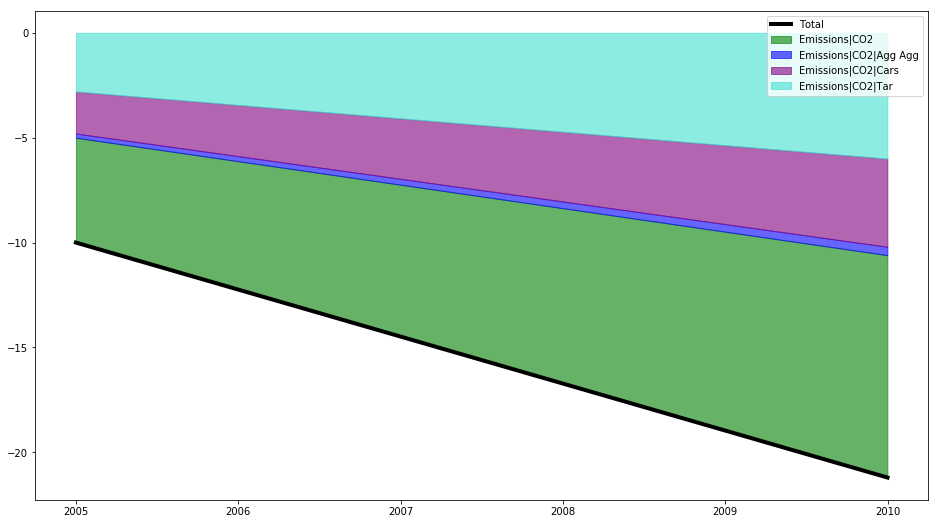

In [27]:
stack_plot_emissions(sdf, sdf.variables())

Take an aggregate of Cars and Tar. Then plot the aggregate of cars and tar alongside the 'Agg Agg' subvariable. 

In [13]:
df.head()

,model,scenario,region,variable,unit,year,value
0,IMG,a_scen,World,Emissions|CO2,Mt CO2/yr,2005,4.0
13,IMG,a_scen,World,Emissions|CO2,Mt CO2/yr,2010,9.4
1,IMG,a_scen,World,Emissions|CO2|Cars,Mt CO2/yr,2005,1.6
14,IMG,a_scen,World,Emissions|CO2|Cars,Mt CO2/yr,2010,3.8
2,IMG,a_scen,World,Emissions|CO2|Tar,Mt CO2/yr,2005,-2.4


In [16]:
df.aggregate

AttributeError: 'IamDataFrame' object has no attribute 'aggregate'